In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
from PIL import Image
import os
from pathlib import Path
from tqdm import tqdm
from torchsummary import summary
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader, Dataset,ConcatDataset

In [34]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:

class SimpsonsDataset(Dataset):

    def __init__(self, files, mode, transforms=None):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.transform = transforms

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    @staticmethod
    def load_sample(file):
        image = Image.open(file)
        image.load()
        return image

    @staticmethod
    def _prepare_sample(image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

    def __getitem__(self, index):
        transform = self.transform
        if transform is None:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()

            return x, y


In [36]:
def imshow(inp, title=None, plt_ax=plt):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [37]:
train_val_dir = Path('train')
test_dir = Path('testset')

In [38]:
train_val_files = sorted(list(train_val_dir.rglob('*.jpg')))
test_files = sorted(list(test_dir.rglob('*.jpg')))

In [39]:
train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.2, random_state=42, stratify=train_val_labels)

train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomResizedCrop(224 ,scale=(0.5, 1)),
    transforms.RandomRotation(25),
    transforms.GaussianBlur(9),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])



train_dataset_augmented = SimpsonsDataset(train_files, mode='train', transforms=train_augmentation)
train_dataset_initial = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

train_dataset = ConcatDataset([train_dataset_initial, train_dataset_augmented])

marge_simpson


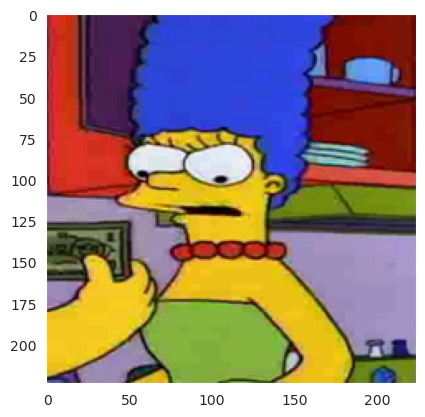

In [40]:
num = np.random.randint(0, len(train_dataset.datasets[0]))

x, y = train_dataset.datasets[0][num]
print(train_dataset.datasets[0].label_encoder.inverse_transform([y]).item())
imshow(x)

chief_wiggum


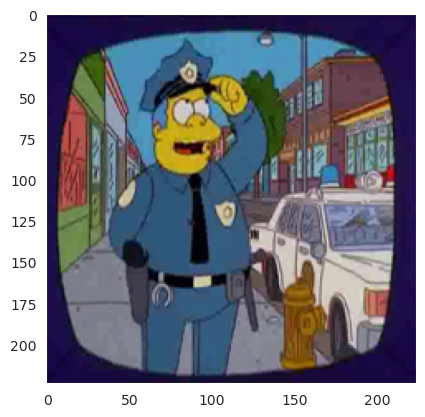

In [41]:
num = np.random.randint(0, len(val_dataset)-1)

x, y = val_dataset[num]
print(val_dataset.label_encoder.inverse_transform([y]).item())
imshow(x)

In [42]:
len(train_dataset), len(val_dataset), len(test_dataset)

(33492, 4187, 991)

In [43]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=42).to(device)

Loaded pretrained weights for efficientnet-b0


In [44]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [45]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [46]:
unfreezed_blocks = 3
for param in model._blocks[:-unfreezed_blocks]:
    param.requires_grad = False


FC_input_size = 1280
model._fc = nn.Sequential(
    nn.Linear(FC_input_size, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 42),
)

In [47]:
BATCH_SIZE = 10
NUM_WORKERS = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [48]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        scheduler.step()

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        train_losses.append(epoch_loss)

        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        val_losses.append(epoch_loss)

    return train_losses, val_losses

In [49]:
model = model.to(device)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),  lr=1e-4, betas=(0.9, 0.999), weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, num_epochs=10)

Epoch 1/10
----------


100%|██████████| 3350/3350 [06:36<00:00,  8.45it/s]


Train Loss: 0.8649 Acc: 0.7761


100%|██████████| 419/419 [00:12<00:00, 32.99it/s]


Val Loss: 0.1928 Acc: 0.9513
Epoch 2/10
----------


100%|██████████| 3350/3350 [06:39<00:00,  8.40it/s]


Train Loss: 0.2497 Acc: 0.9349


100%|██████████| 419/419 [00:12<00:00, 32.86it/s]


Val Loss: 0.1408 Acc: 0.9666
Epoch 3/10
----------


100%|██████████| 3350/3350 [06:38<00:00,  8.42it/s]


Train Loss: 0.1733 Acc: 0.9547


100%|██████████| 419/419 [00:12<00:00, 32.91it/s]


Val Loss: 0.1395 Acc: 0.9701
Epoch 4/10
----------


100%|██████████| 3350/3350 [06:38<00:00,  8.41it/s]


Train Loss: 0.1098 Acc: 0.9710


100%|██████████| 419/419 [00:12<00:00, 32.92it/s]


Val Loss: 0.1006 Acc: 0.9807
Epoch 5/10
----------


100%|██████████| 3350/3350 [06:38<00:00,  8.41it/s]


Train Loss: 0.0890 Acc: 0.9764


100%|██████████| 419/419 [00:12<00:00, 33.02it/s]


Val Loss: 0.1026 Acc: 0.9787
Epoch 6/10
----------


100%|██████████| 3350/3350 [06:38<00:00,  8.41it/s]


Train Loss: 0.0808 Acc: 0.9785


100%|██████████| 419/419 [00:12<00:00, 32.90it/s]


Val Loss: 0.0943 Acc: 0.9797
Epoch 7/10
----------


100%|██████████| 3350/3350 [06:39<00:00,  8.39it/s]


Train Loss: 0.0634 Acc: 0.9831


100%|██████████| 419/419 [00:12<00:00, 32.67it/s]


Val Loss: 0.0818 Acc: 0.9830
Epoch 8/10
----------


100%|██████████| 3350/3350 [06:40<00:00,  8.36it/s]


Train Loss: 0.0562 Acc: 0.9855


100%|██████████| 419/419 [00:12<00:00, 32.82it/s]


Val Loss: 0.0867 Acc: 0.9828
Epoch 9/10
----------


100%|██████████| 3350/3350 [06:39<00:00,  8.38it/s]


Train Loss: 0.0582 Acc: 0.9852


100%|██████████| 419/419 [00:12<00:00, 32.66it/s]


Val Loss: 0.0992 Acc: 0.9814
Epoch 10/10
----------


100%|██████████| 3350/3350 [06:41<00:00,  8.34it/s]


Train Loss: 0.0477 Acc: 0.9878


100%|██████████| 419/419 [00:12<00:00, 32.73it/s]

Val Loss: 0.0835 Acc: 0.9847


<AxesSubplot: >

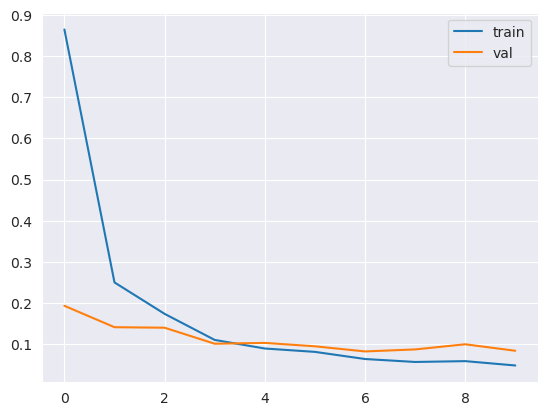

In [51]:
sns.lineplot(x=range(len(train_losses)), y=train_losses, label='train')
sns.lineplot(x=range(len(val_losses)), y=val_losses, label='val')

In [53]:
torch.save(model.state_dict(), 'model.pt')

In [54]:
loaded = torch.load('model.pt')

In [57]:
def predict(model, test_loader):
    model.eval()
    predictions = []
    for inputs in tqdm(test_loader):
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

In [58]:
predictions = predict(model, test_loader)

100%|██████████| 100/100 [00:03<00:00, 32.70it/s]


In [77]:
solution = pd.DataFrame({'Id': test_dataset.files, 'Expected': predictions})
solution['Expected'] = solution['Expected'].apply(lambda x: train_dataset.datasets[0].label_encoder.inverse_transform([x]).item())
solution['Id'] = solution['Id'].apply(lambda x: str(x).split('/')[-1])
solution.to_csv('solution.csv', index=False)